## TODO:

* shuffle data in each epoch?
* different inference graph
* seeding initial state as a placeholder ?
* dropout, more layers, ...

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import tensorflow as tf
import itertools

## Prepare vocabulary, train sentences and labels

In [2]:
with open('../txa-hw/hw2/pg1661.txt', encoding='utf-8') as f:
    original_text = f.read()
# Strip meta info and table of contents at the beginning and licence at the end -> use only the book itself.
text = original_text[re.search('ADVENTURE I', original_text).start() : re.search('End of the Project Gutenberg EBook', original_text).start()]
text = text.lower().strip()
text = re.sub('\s+', ' ', text) # replace whitespaces with single space

In [3]:
sentences = nltk.sent_tokenize(text)

In [4]:
token_start = 'START'
token_end = 'END'
tok_sentences = [[token_start] + [w for w in nltk.word_tokenize(s) if w] + [token_end] for s in sentences]

In [5]:
freq_dist = nltk.FreqDist(itertools.chain(*tok_sentences))

In [6]:
freq_threshold = 3
vocab = [(k,v) for k,v in freq_dist.items() if v >= freq_threshold]
id_word = [v[0] for v in vocab]
word_id = {w:i for i,w in enumerate(id_word)}

# drop all words less frequent than freq_threshold
tok_sentences = [[w for w in s if w in word_id] for s in tok_sentences]

In [7]:
max_len = 50

# cut all sentences to max_len
tok_sentences = [s[:max_len] for s in tok_sentences]

In [8]:
X = np.asarray([[word_id[w] for w in s[:-1]] for s in tok_sentences])
Y = np.asarray([[word_id[w] for w in s[1:]] for s in tok_sentences])  # shift-by-1 X, next-word prediction

X_lens = [len(x) for x in X]
Y_lens = [len(y) for y in Y]

# pad with zeros to max_len
X = [np.pad(x, (0,max_len-len(x)), 'constant') for x in X]
Y = [np.pad(y, (0,max_len-len(y)), 'constant') for y in Y]

## Build graph


We have an embedding layer (no bias, no activation), a RNN layer using LSTM cell, a projection layer (bias, no activation) to vocabulary_size and a final softmax layer providing with nex_word probability distribution.

In [9]:
num_steps = max_len  # max. number of timesteps
vocab_size = len(vocab)
embeding_size = 100
batch_size = 32
lstm_size = 30 # n_hidden and state_size?

In [10]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [11]:
words_input = tf.placeholder(tf.int32, [batch_size, num_steps], name='words_input')   # [B, T]
words_input_lengths = tf.placeholder(tf.int32, [batch_size], name='words_input_lengths')   # [B]
words_target  = tf.placeholder(tf.int32, [batch_size, num_steps], name='words_target')   # [B, T]

# Embedding layer
embedding = tf.Variable(tf.truncated_normal([vocab_size, embeding_size]), name='E')   # [V, E]
embedded_words = tf.nn.embedding_lookup(embedding, words_input) # [B, T, E]

# RNN layer
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
outputs, final_state = tf.nn.dynamic_rnn(lstm, embedded_words, dtype=tf.float32, sequence_length=words_input_lengths)

# Projection and softmax
softmax_w = tf.Variable(tf.truncated_normal([lstm_size, vocab_size]), dtype=tf.float32, name='W_softmax')   # [lstm_size, V]
softmax_b = tf.Variable(tf.zeros([vocab_size]), name='b_softmax')   # [V]
logits = tf.tensordot(outputs, softmax_w, axes=[[2],[0]]) + tf.reshape(softmax_b, [1,1,-1]) # [B, T, V]
probabilities = tf.nn.softmax(logits) # [B, T, V]

In [12]:
# https://stackoverflow.com/a/42606537
gather_p = lambda params, indices : tf.gather_nd(params, tf.stack([tf.tile(tf.expand_dims(tf.range(tf.shape(indices)[0]), 1), [1, tf.shape(indices)[1]]), tf.transpose(tf.tile(tf.expand_dims(tf.range(tf.shape(indices)[1]), 1), [1, tf.shape(indices)[0]])), indices], 2))

## Calculate loss

Loss is taken from show and tell paper as negative likelihood of a correct (target) word for each step
$$\mathrm{loss} = - \sum_t \log p(\mathrm{correct\_word}_t)$$
It is then averaged over batch.

In [13]:
target_probas = gather_p(probabilities, words_target)   # [B, T]. Probabilities of the correct word
log_likelihood = - tf.log(target_probas)   # [B, T]. Negative log likelihood
mask = tf.sequence_mask(words_input_lengths, maxlen=num_steps, dtype=tf.float32) # [B, T]
masked_ll = tf.multiply(log_likelihood, mask)   # [B, T]. Masking by seq. lenghts
loss = tf.reduce_sum(masked_ll) / batch_size   # average over batch, sum over time 

## Train model

In [14]:
learning_rate = 1
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [15]:
sess.run(tf.global_variables_initializer())
losses = []

In [17]:
train_size = 500  # limit training set to this number of first sentences
n_epochs = 10

In [18]:
num_batches = train_size // batch_size

for epoch in range(n_epochs):
    print('epoch', epoch+1)
    for i in range(num_batches):
        start = i*batch_size
        end = (i+1)*batch_size
        x, y, x_lens = X[start:end], Y[start:end], X_lens[start:end]
        _, loss_value = sess.run([train_op, loss], feed_dict={
            words_input: np.array(x), 
            words_input_lengths: np.reshape(x_lens, (-1)),
            words_target: np.array(y)
        })
        losses.append(loss_value)
print('finished')

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
finished


final loss 58.0561


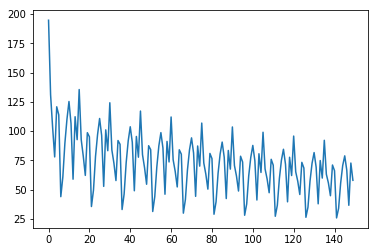

In [19]:
print('final loss', losses[-1])
plt.plot(losses)

## Generate sentences

In [195]:
seq = ['START']
seq = [word_id[s] for s in seq]


for i in range(len(seq)-1, 20):
    p = sess.run(probas[len(seq)-1], feed_dict={
        words_input: np.reshape(np.pad(seq, (0,max_len-len(seq)), 'edge'), (1,-1)),
        words_input_lengths: np.reshape(len(seq)+1, (1))
    })
#     max_id = np.argmax(p)
    p = p.reshape([-1])
    max_id = np.random.choice(list(range(len(p))), p=p)
    seq.append(max_id)
#     print(seq)
print(' '.join(id_word[s] for s in seq))

ValueError: Cannot feed value of shape (1, 50) for Tensor 'words_input:0', which has shape '(32, 50)'